In [1]:
import IPython.display as idp
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pyroomacoustics as pra
import random
import scipy.signal
import tqdm
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
print(os.listdir('/proj/vondrick2/datasets/FMA/fma_large/'))
src_dp = '/proj/vondrick2/datasets/FMA/fma_large/143/'
xs = []
for i in range(2):
    src_fn = random.choice(os.listdir(src_dp))
    src_fp = os.path.join(src_dp, src_fn)
    x, Fs = librosa.load(src_fp)
    x = x[:Fs * 6]
    xs.append(x)
    print(src_fn, x.shape, Fs, x.shape[0] / Fs, x.min(), x.max())

['121', '072', '050', '027', '097', '123', '026', '028', '143', '098', '125', '049', '124', '122', '126', 'README.txt']


/home/bv2279/miniconda3/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


143915.mp3 (132300,) 22050 6.0 -0.52746487 0.66487515


/home/bv2279/miniconda3/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


143841.mp3 (132300,) 22050 6.0 -0.46047032 0.4246836


In [3]:
for x in xs:
    idp.display(Audio(x, rate=Fs))

In [4]:
# Geometry of the room and location of sources and microphones.
# Microphone moves a bit from left (src 1) to right (src 2).
room_dim = np.array([10.1, 7.1, 3.1])
src_loc = np.array([[2.51, 4.52, 1.23],
                    [7.54, 4.55, 1.26]])
mic_loc = np.c_[[3.07, 1.58, 1.49],
                [4.07, 1.58, 1.49],
                [5.07, 1.58, 1.49]]
room = pra.ShoeBox(room_dim, fs=Fs, absorption=0.25, max_order=17)
# src_x1 = np.random.randn(Fs * 5)
# src_x2 = np.random.randn(Fs * 5)
room.add_source(src_loc[0], signal=xs[0])
room.add_source(src_loc[1], signal=xs[1])
room.add_microphone_array(mic_loc)
room.simulate()

room.rir: 3 2 (11412,)
mic_signals: (3, 143712)


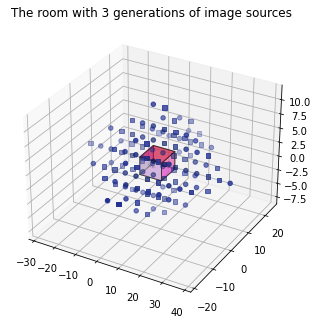

In [5]:
# # room.rir = list of lists (microphone -> source -> actual impulse response).
print('room.rir:', len(room.rir), len(room.rir[0]), room.rir[0][0].shape)
mic_signals = room.mic_array.signals
print('mic_signals:', mic_signals.shape)
room.plot(img_order=3)
plt.title('The room with 3 generations of image sources')
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html

(129,) (1035,) (129, 1035)


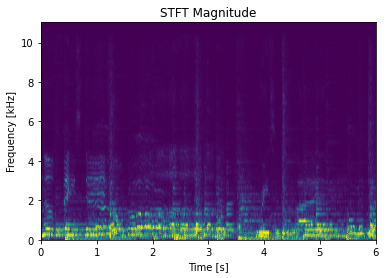

(129,) (1035,) (129, 1035)


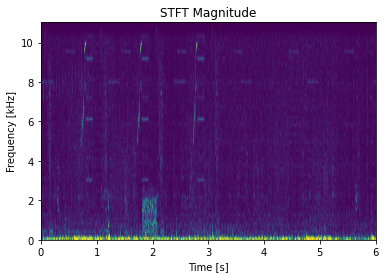

In [6]:
for x in xs:
    f, t, Zxx = scipy.signal.stft(x, Fs, nperseg=256)
    print(f.shape, t.shape, Zxx.shape)
    plt.figure()
    plt.pcolormesh(t, f / 1e3, np.abs(Zxx), vmin=0, vmax=0.04, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [s]')
    plt.show()
    idp.display(Audio(x, rate=Fs))

(129,) (1124,) (129, 1124)


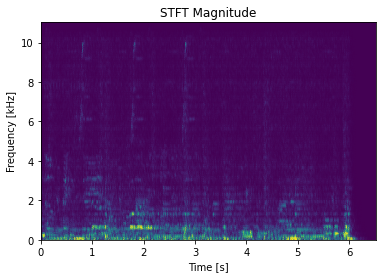

(129,) (1124,) (129, 1124)


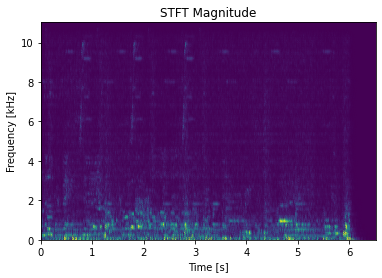

(129,) (1124,) (129, 1124)


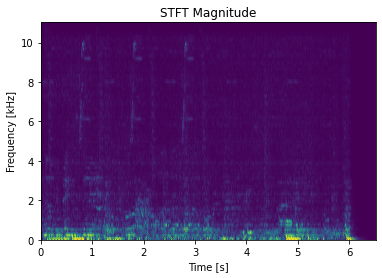

In [7]:
for y in mic_signals:
    f, t, Zxx = scipy.signal.stft(y, Fs, nperseg=256)
    print(f.shape, t.shape, Zxx.shape)
    plt.figure()
    plt.pcolormesh(t, f / 1e3, np.abs(Zxx), vmin=0, vmax=0.04, shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [s]')
    plt.show()
    idp.display(Audio(y, rate=Fs))

In [28]:
# # room.rir = list of lists (microphone -> source -> actual impulse response).
rir_lens = [[len(room.rir[i][j]) for i in range(3)] for j in range(2)]
mrl = np.min(rir_lens)
print(rir_lens, mrl)

[[11412, 11347, 11283], [11154, 11218, 11282]] 11154


Energy of rir: 0.3761204065868973
Energy of rir: 0.33406534786461967
Energy of rir: 0.31081376628699897


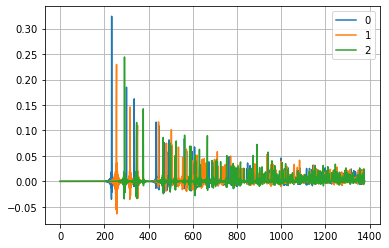

In [83]:
plt.figure()
for i in range(3):
    plt.plot(room.rir[i][0][:int(Fs / 16)], label=i)
    print('Energy of rir:', np.sum(np.square(np.abs(room.rir[i][0]))))
plt.grid(True)
plt.legend()
plt.show()

Energy of rir: 0.3761204065868973
Energy of rir: 0.33406534786461967
Energy of rir: 0.31081376628699897


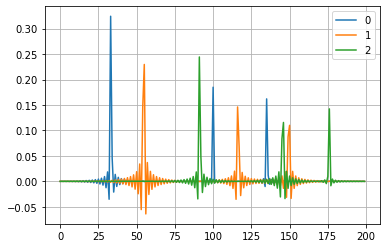

In [82]:
plt.figure()
for i in range(3):
    plt.plot(room.rir[i][0][200:400], label=i)
plt.grid(True)
plt.legend()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html

(65,) (178,) (65, 178) complex128 (0.005052352278368606+0j)


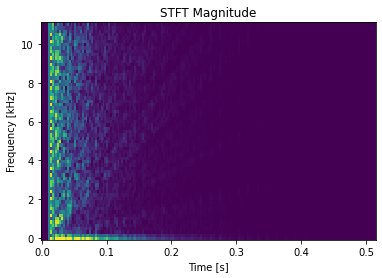

(65,) (100,) (65, 100) float64 2.9102559717782417e-05


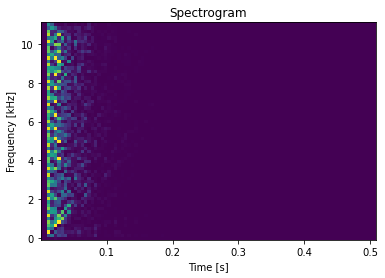

In [60]:
f, t, Zxx = scipy.signal.stft(room.rir[i][0], Fs, nperseg=128)
print(f.shape, t.shape, Zxx.shape, Zxx.dtype, Zxx.max())
plt.figure()
plt.pcolormesh(t, f / 1e3, np.abs(Zxx), vmin=0, vmax=0.004, shading='nearest')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')
plt.show()

f, t, Sxx = scipy.signal.spectrogram(room.rir[i][0], Fs, nperseg=128, scaling='spectrum')
print(f.shape, t.shape, Sxx.shape, Sxx.dtype, Sxx.max())
plt.figure()
plt.pcolormesh(t, f / 1e3, np.abs(Sxx), vmin=0, vmax=0.004 ** 2, shading='nearest')
plt.title('Spectrogram')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [s]')
plt.show()

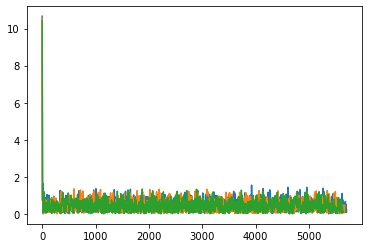

In [73]:
plt.figure()
for i in range(3):
    my_fft = scipy.fft.fft(room.rir[i][0])
    my_fft = my_fft[:len(my_fft) // 2]
    plt.plot(np.abs(my_fft))
plt.show()

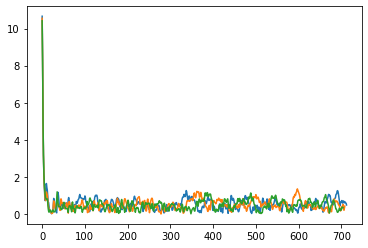

In [75]:
plt.figure()
for i in range(3):
    my_fft = scipy.fft.fft(room.rir[i][0])
    my_fft = my_fft[:len(my_fft) // 16]
    plt.plot(np.abs(my_fft))
plt.show()

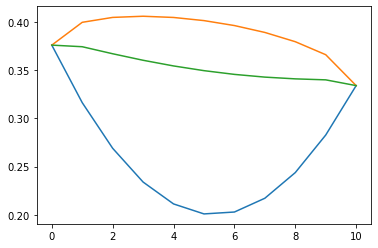

In [92]:
import numpy as np
lin_es = []
sq_es = []
cst_es = []
for t in np.linspace(0, 1, 11):
    lin_ipol = room.rir[0][0][:mrl] * (1 - t) + room.rir[1][0][:mrl] * t
    sq_ipol = room.rir[0][0][:mrl] * np.sqrt(1 - t) + room.rir[1][0][:mrl] * np.sqrt(t)
    cst_ipol = room.rir[0][0][:mrl] * np.power(1 - t, 0.6) + room.rir[1][0][:mrl] * np.power(t, 0.6)
    lin_energy = np.sum(np.square(np.abs(lin_ipol)))
    sq_energy = np.sum(np.square(np.abs(sq_ipol)))
    cst_energy = np.sum(np.square(np.abs(cst_ipol)))
    lin_es.append(lin_energy)
    sq_es.append(sq_energy)
    cst_es.append(cst_energy)
plt.figure()
plt.plot(lin_es)
plt.plot(sq_es)
plt.plot(cst_es)
plt.show()